In [45]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [46]:
df = pd.read_csv("ITSM_data.csv", low_memory=False)
df.head(3)  # Verify structure matches your sample
df.info()  # Check dtypes and missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46606 entries, 0 to 46605
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   CI_Name                     46606 non-null  object 
 1   CI_Cat                      46495 non-null  object 
 2   CI_Subcat                   46495 non-null  object 
 3   WBS                         46606 non-null  object 
 4   Incident_ID                 46606 non-null  object 
 5   Status                      46606 non-null  object 
 6   Impact                      46606 non-null  object 
 7   Urgency                     46606 non-null  object 
 8   Priority                    45226 non-null  float64
 9   number_cnt                  46606 non-null  float64
 10  Category                    46606 non-null  object 
 11  KB_number                   46606 non-null  object 
 12  Alert_Status                46606 non-null  object 
 13  No_of_Reassignments         466

In [47]:
drop_cols = [
    'Incident_ID', 'Status', 'Open_Time', 'Reopen_Time', 
    'Resolved_Time', 'Close_Time', 'KB_number', 'Alert_Status',
    'Related_Interaction', 'Related_Change', 'WBS'
]
df = df.drop(columns=[col for col in drop_cols if col in df.columns])

In [48]:
# Convert to numeric, coercing errors to NaN
df['Priority'] = pd.to_numeric(df['Priority'], errors='coerce')

# Drop rows where Priority is NaN/NS/NA (invalid labels)
df = df.dropna(subset=['Priority'])

# Now create binary target safely
df['is_high_priority'] = df['Priority'].apply(lambda x: 1 if x in [1, 2] else 0)

In [ ]:
# Clean Handle_Time_hrs (example for one format)
# 1. Clean numeric columns with special strings
def clean_numeric(col):
    return pd.to_numeric(col, errors='coerce').fillna(0)  # Converts 'NS'/'NA' to 0

numeric_cols = ['Impact', 'Urgency', 'No_of_Reassignments', 
                'No_of_Related_Interactions', 'No_of_Related_Incidents']
for col in numeric_cols:
    df[col] = clean_numeric(df[col])

# 2. Verify all numeric columns
print(df[numeric_cols].dtypes)

def clean_handle_time(x):
    if isinstance(x, str): 
        return sum(float(i.replace(',', '.')) for i in x.split(','))
    return x

df['Handle_Time_hrs'] = df['Handle_Time_hrs'].apply(clean_handle_time)

# Create new features
df['is_reassigned'] = (df['No_of_Reassignments'] > 0).astype(int)
df['interaction_ratio'] = df['No_of_Related_Interactions'] / (df['No_of_Related_Incidents'] + 1)

Impact                          int64
Urgency                       float64
No_of_Reassignments           float64
No_of_Related_Interactions    float64
No_of_Related_Incidents       float64
dtype: object


In [50]:
# Encode ONLY true categorical columns (not numeric ones)
cat_cols = ['CI_Name', 'CI_Cat', 'CI_Subcat', 'Category', 'Closure_Code']
df[cat_cols] = df[cat_cols].astype(str)  # Ensure string type

# Label Encoding
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [51]:
# Check for remaining non-numeric values
non_numeric = df.select_dtypes(include=['object', 'category'])
assert non_numeric.empty, f"Non-numeric cols remaining: {non_numeric.columns.tolist()}"

In [52]:
X = df.drop(['Priority', 'is_high_priority'], axis=1)
y = df['is_high_priority']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42
)

In [53]:
from sklearn.impute import SimpleImputer

# 1. Impute missing values (NaNs)
imputer = SimpleImputer(strategy='median')  # For numeric features
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# 2. Now scale your data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [54]:
model = SVC(
    kernel='rbf',
    class_weight='balanced',
    probability=True,
    random_state=42
)

model.fit(X_train, y_train)

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,True
,tol,0.001
,cache_size,200
,class_weight,'balanced'
,verbose,False


In [55]:
y_pred = model.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[13350     3]
 [    6   209]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13353
           1       0.99      0.97      0.98       215

    accuracy                           1.00     13568
   macro avg       0.99      0.99      0.99     13568
weighted avg       1.00      1.00      1.00     13568



C:\Users\akash\AppData\Local\Temp\ipykernel_20580\4192073684.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


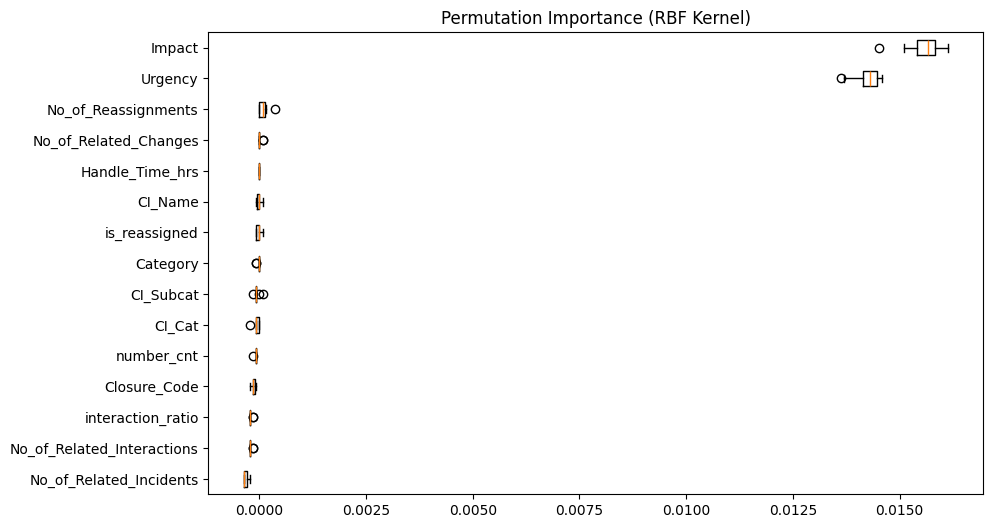

In [56]:
from sklearn.inspection import permutation_importance

# Calculate permutation importance
result = permutation_importance(
    model,  # Your RBF-kernel SVM
    X_test_scaled, 
    y_test,
    n_repeats=10,
    random_state=42
)

# Plot
sorted_idx = result.importances_mean.argsort()
plt.figure(figsize=(10,6))
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=X.columns[sorted_idx]
)
plt.title("Permutation Importance (RBF Kernel)")
plt.show()

In [57]:
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto']
}

grid = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), 
                   param_grid, cv=5, scoring='f1')
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
best_model = grid.best_estimator_

Best parameters: {'C': 1, 'gamma': 'auto'}
